In [1]:
import os
import torch
import numpy as np
import pandas as pd
from laplace import Laplace
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

from torch.autograd import Variable
from torch.optim.swa_utils import AveragedModel, SWALR


#os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
os.chdir('g:\\Mi unidad\\MsC_UE\\Dissertation\\Pytorch')

# MNIST Dataset
from Toy_Models.toy_model import get_model

# Einsum networks
from src.EinsumNetwork import Graph, EinsumNetwork
import src.utils


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
n_models = 5
file_models = [os.path.join(os.getcwd(),"Toy_Models","TM_m"+str(n + 1)+".pth") for n in range(5)]

In [3]:
models = [get_model().to(device) for _ in range(n_models)]

for file, model in zip(file_models,models):
    model.load_state_dict(torch.load(file))
    model.eval()

In [4]:
dataset = pd.read_csv(os.path.join(os.getcwd(),"Toy_Models","toy_dataset.csv"),index_col=0).to_numpy()
x,y = torch.from_numpy(dataset[:,0]).float().to(device),torch.from_numpy(dataset[:,1]).float().to(device)

x,y = x.reshape(-1,1),y.reshape(-1,1)

dataset = TensorDataset(x,y)
dataset = DataLoader(dataset,batch_size=dataset.tensors[0].size(0))
#X,Y = next(iter(dataset))

In [6]:
# Multi SWAG

learningRate = 0.0035 
epochs = 1000
n_models = 5


models_ = [get_model().to(device) for _ in range(n_models)]
SWAG_models = []

In [8]:

criterion = torch.nn.MSELoss() 

for model in models_:
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

    swa_model = AveragedModel(model)
     #scheduler = CosineAnnealingLR(optimizer, T_max=100)
    swa_start = int((epochs)*(.75))
    swa_scheduler = SWALR(optimizer, swa_lr=0.003)

    for epoch in range(1,epochs+1):
        # Converting inputs and labels to Variable
        inputs, labels= Variable(x.to(device).reshape(-1,1)),Variable(y.float().to(device).reshape(-1,1))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs)

        # get loss for the predicted output
        loss = criterion(outputs, labels)
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, loss {loss.item():0.4f}')


        if epochs > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()


    torch.optim.swa_utils.update_bn(inputs, swa_model)

    SWAG_models.append(swa_model)

Epoch 10, loss 842.5085
Epoch 20, loss 793.5656
Epoch 30, loss 700.3209
Epoch 40, loss 579.3398
Epoch 50, loss 477.8806
Epoch 60, loss 412.2599
Epoch 70, loss 373.2849
Epoch 80, loss 350.2094
Epoch 90, loss 335.8620
Epoch 100, loss 325.9022
Epoch 110, loss 317.9361
Epoch 120, loss 310.8276
Epoch 130, loss 304.1705
Epoch 140, loss 297.9055
Epoch 150, loss 292.0794
Epoch 160, loss 286.7324
Epoch 170, loss 281.8691
Epoch 180, loss 277.4630
Epoch 190, loss 273.4676
Epoch 200, loss 269.8250
Epoch 210, loss 266.4739
Epoch 220, loss 263.3547
Epoch 230, loss 260.4111
Epoch 240, loss 257.5910
Epoch 250, loss 254.8449
Epoch 260, loss 252.1250
Epoch 270, loss 249.3831
Epoch 280, loss 246.5708
Epoch 290, loss 243.6389
Epoch 300, loss 240.5393
Epoch 310, loss 237.2275
Epoch 320, loss 233.6659
Epoch 330, loss 229.8270
Epoch 340, loss 225.6947
Epoch 350, loss 221.2661
Epoch 360, loss 216.5518
Epoch 370, loss 211.5756
Epoch 380, loss 206.3739
Epoch 390, loss 200.9935
Epoch 400, loss 195.4879
Epoch 410

In [9]:
SWAG_models[0](x)

tensor([[-32.1254],
        [-31.3239],
        [-28.7760],
        [-26.5551],
        [-22.8142],
        [-21.2762],
        [-16.9595],
        [-16.3929],
        [-15.2263],
        [-14.9077],
        [-13.9635],
        [ -8.6147],
        [ -2.8351],
        [  0.9134],
        [  2.0864],
        [  3.4662],
        [  4.1307],
        [  4.3142],
        [ 13.6899],
        [ 17.6854],
        [ 26.7129],
        [ 27.0421],
        [ 31.9323],
        [ 33.6453],
        [ 36.9341],
        [ 40.4004],
        [ 43.6588],
        [ 43.7569],
        [ 48.0549],
        [ 48.6956]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [258]:
LA = []
LLA_K = []


for model in models:
    la = Laplace(model, 'regression',
                subset_of_weights='last_layer',
                hessian_structure='diag')
        
    la.fit(dataset)

    log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)

    hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

    for i in range(1000):
        hyper_optimizer.zero_grad()
        neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
        neg_marglik.backward()
        hyper_optimizer.step()

    LA.append(la)

    la = Laplace(model, 'regression', subset_of_weights='last_layer', hessian_structure="kron")
                
    la.fit(dataset)
    
    log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)

    hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

    for i in range(1000):
        hyper_optimizer.zero_grad()
        neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
        neg_marglik.backward()
        hyper_optimizer.step()
    LLA_K.append(la)

In [259]:
posterior_mean =torch.column_stack( [LA[n].mean for n in range(n_models)])
posterior_var = torch.column_stack([1/ LA[n].posterior_precision for n in range(n_models)])


In [260]:
num_var = posterior_mean.size()[0]

exponential_family = EinsumNetwork.NormalArray
exponential_family_args = {'min_var': 1e-6, 'max_var': 0.1}


#classes = [7]
K = 5

structure = 'binary-trees'

# 'binary-trees'
depth = 2
num_repetitions = 2

num_epochs = 5
batch_size = 100
online_em_frequency = 1
online_em_stepsize = 0.05

Graph check passed.


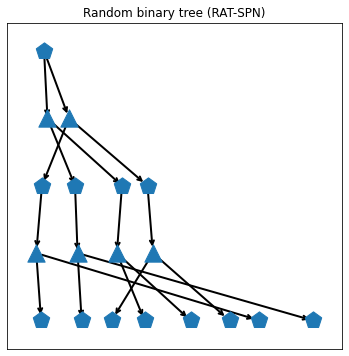

In [261]:
graph = Graph.random_binary_trees(num_var=num_var, depth=depth, num_repetitions=num_repetitions)

_, msg = Graph.check_graph(graph)
print(msg)

plt.figure(figsize=(6, 6))
plt.clf()
plt.title("Random binary tree (RAT-SPN)")
Graph.plot_graph(graph)
plt.show()

In [262]:
posterior_mean = posterior_mean.unsqueeze(2).repeat(1,1,num_repetitions)

posterior_var = posterior_var.unsqueeze(2).repeat(1,1,num_repetitions)

initializer = torch.cat((posterior_mean.unsqueeze(3), posterior_var.unsqueeze(3)), -1)

In [263]:
initializer.size()

torch.Size([51, 5, 2, 2])

In [264]:
ly = torch.ones((5,5))/n_models**2

ly1 = ly.unsqueeze(2).repeat(1,1,5).unsqueeze(3).repeat(1,1,1,4)

In [265]:
ly2 = ly.unsqueeze(2).unsqueeze(3).repeat(1,1,1,2)

In [266]:
ly3 = torch.ones(2)/2

ly3 = ly3[None,None,:]

In [267]:
args = EinsumNetwork.Args(
        num_var=num_var,
        num_dims=1,
        num_classes=1,
        num_sums=K,
        num_input_distributions=K,
        exponential_family=exponential_family,
        exponential_family_args=exponential_family_args,
        online_em_frequency=online_em_frequency,
        online_em_stepsize=online_em_stepsize)

einet = EinsumNetwork.EinsumNetwork(graph, args)
#einet.initialize()
einet.initialize({0:initializer, 1:ly1, 2:ly2, 3:ly3})
einet.to(device)
print(einet)

EinsumNetwork(
  (einet_layers): ModuleList(
    (0): FactorizedLeafLayer(
      (ef_array): NormalArray()
    )
    (1): EinsumLayer()
    (2): EinsumLayer()
    (3): EinsumMixingLayer()
  )
)


In [268]:
ensamble_mean = np.average(np.stack([LA[n].mean.cpu().numpy() for n in range(n_models)]),axis=0,weights=np.ones(n_models)/n_models)

ensamble_var = np.average(np.stack([1/ LA[n].posterior_precision.cpu().detach().numpy() for n in range(n_models)]),axis=0,weights=(np.ones(n_models)/n_models)**2)

samples = einet.sample(10000).cpu().numpy()


col_mean = np.nanmean(samples, axis=0)

inds = np.where(np.isnan(samples))

samples[inds] = np.take(col_mean, inds[1])



g:\Mi unidad\MsC_UE\Dissertation\Pytorch\src\EinsumNetwork\SumLayer.py:445: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dist_idx_left = idx // self.num_input_dist


In [269]:
import numpy.ma as ma
cov = ma.cov(ma.masked_invalid(samples),rowvar=False).data

In [270]:
cov_pc = torch.from_numpy(cov)

Text(0, 0.5, 'weights')

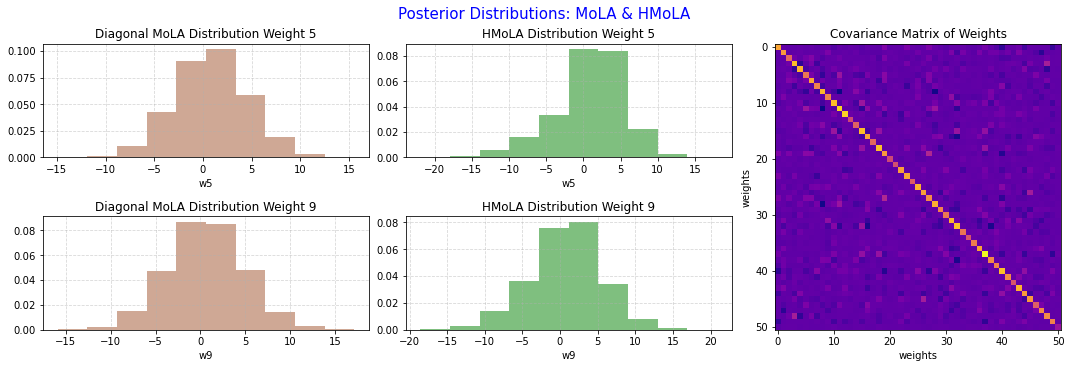

In [275]:
nx, ny = 5,9

xs = samples[:,nx]
ys = samples[:,ny]

bad_indices = np.isnan(xs) | np.isnan(ys)
good_indices = ~bad_indices
good_x = xs[good_indices]
good_y = ys[good_indices]

xx = np.random.normal(ensamble_mean[nx],np.sqrt(ensamble_var[nx]),25000)
yy = np.random.normal(ensamble_mean[ny],np.sqrt(ensamble_var[ny]),25000)


fig,axs = plt.subplot_mosaic(
    """
    ABE
    CDE
    """
    ,figsize=(15, 5),constrained_layout=True)

fig.suptitle("Posterior Distributions: MoLA & HMoLA",fontsize = 15,color="blue")

axs["A"].hist(xx,density=True, label = "E", color = "sienna",alpha =0.5)
axs["A"].set_title(f"Diagonal MoLA Distribution Weight {nx}")
axs["A"].set_xlabel(f"w{nx}")
axs["A"].grid(True, alpha =0.5,linestyle = "--")

axs["C"].hist(yy,density=True, color = "sienna",alpha =0.5)
axs["C"].set_title(f"Diagonal MoLA Distribution Weight {ny}")
axs["C"].set_xlabel(f"w{ny}")
axs["C"].grid(True, alpha =0.5,linestyle = "--")


axs["B"].hist(samples[:,nx],density=True, color = "green",alpha =0.5)
axs["B"].set_title(f"HMoLA Distribution Weight {nx}")
axs["B"].set_xlabel(f"w{nx}")
axs["B"].grid(True, alpha =0.5,linestyle = "--")


axs["D"].hist(samples[:,ny],density=True, color = "green",alpha =0.5)
axs["D"].set_title(f"HMoLA Distribution Weight {ny}")
axs["D"].set_xlabel(f"w{ny}")
axs["D"].grid(True, alpha =0.5,linestyle = "--")

from mpl_toolkits.axes_grid1 import make_axes_locatable

ax1 = axs["E"].imshow(cov,cmap='plasma')
#divider = make_axes_locatable(ax1)

#cax = divider.append_axes('right', size='5%', pad=0.05)

#fig.colorbar(ax1,ax=axs["E"],orientation ="vertical")
#cb.axs["E"].tick_params(labelsize=14)

axs["E"].set_title(f"Covariance Matrix of Weights")
axs["E"].set_xlabel(f"weights")
axs["E"].set_ylabel(f"weights")


In [211]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters

fs = list()

for sample in torch.from_numpy(samples).to(device):

    for n in range(n_models):
        vector_to_parameters(sample, LA[n].model.last_layer.parameters())        
        fs.append(LA[n].model(x.to(device)).detach())

for n in range(n_models):
    vector_to_parameters(LA[n].mean, LA[n].model.last_layer.parameters())

fs = torch.stack(fs)

[]

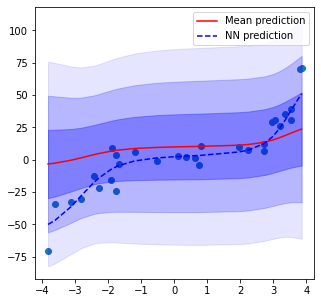

In [212]:
mean_pred,var_pred = fs.mean(dim=0), fs.var(dim=0)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))


f_mu = mean_pred.squeeze().detach().cpu().numpy()
var_pred = var_pred.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(var_pred**2 + LA[0].sigma_noise.item()**2)

output = models[0](x)

axs.scatter(x.cpu().numpy(),y.cpu().numpy())
axs.plot(x.cpu().numpy(), f_mu, label='Mean prediction', color = "red")
axs.plot(x.cpu().numpy(), output.detach().cpu().numpy(), "--",label='NN prediction',color="blue")
axs.fill_between(x.cpu().numpy().reshape(-1), f_mu+pred_std,f_mu-pred_std,alpha=0.3, color = "blue")
axs.fill_between(x.cpu().numpy().reshape(-1), f_mu+2*pred_std,f_mu-2*pred_std,alpha=0.2, color = "blue")
axs.fill_between(x.cpu().numpy().reshape(-1), f_mu+3*pred_std,f_mu-3*pred_std,alpha=0.1, color = "blue")

axs.legend()
plt.plot()

In [213]:
### Predictive Storing
#xx = np.sort(np.random.uniform(-6,6,40))

mu,sigma2 = [],[]

for n in range(0,len(LA)):
    #sigma2.append(LA[n]._glm_predictive_distribution(torch.from_numpy(xx).float().reshape(-1,1).to(device))[1].reshape(-1,1) + LA[n].sigma_noise**2)
    sigma2.append(LA[n]._glm_predictive_distribution(x)[1].reshape(-1,1) + LA[n].sigma_noise**2)

    #mu.append(LA[n]._glm_predictive_distribution(torch.from_numpy(xx).float().reshape(-1,1).to(device))[0])
    mu.append(LA[n]._glm_predictive_distribution(x)[0])

sigma2 = torch.column_stack(sigma2)
mu = torch.column_stack(mu)

In [214]:
num_var = len(LA)

exponential_family = EinsumNetwork.NormalArray
#exponential_family_args = {'min_var': 1e-6, 'max_var': 0.1}

#classes = [7]
K = 5

structure = 'binary-trees'

# 'binary-trees'
depth = 2
num_repetitions = 2

num_epochs = 5
batch_size = 100
online_em_frequency = 1
online_em_stepsize = 0.05


args = EinsumNetwork.Args(
        num_var=num_var,
        num_dims=1,
        num_classes=1,
        num_sums=K,
        num_input_distributions=K,
        exponential_family=exponential_family,
        exponential_family_args=exponential_family_args,
        online_em_frequency=online_em_frequency,
        online_em_stepsize=online_em_stepsize)

Graph check passed.


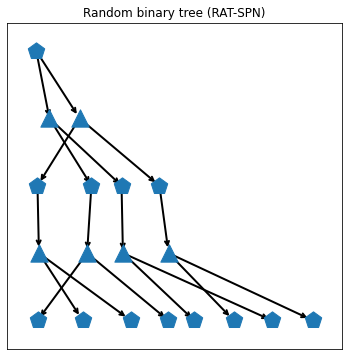

In [215]:
graph = Graph.random_binary_trees(num_var=num_var, depth=depth, num_repetitions=num_repetitions)

_, msg = Graph.check_graph(graph)
print(msg)

plt.figure(figsize=(6, 6))
plt.clf()
plt.title("Random binary tree (RAT-SPN)")
Graph.plot_graph(graph)
plt.show()

In [216]:
mu_pp , var_pp = [],[]
mu_pp2 , var_pp2 = [],[]

for nn in range(mu.size()[0]):

    mu_n = mu[nn,:]
    sigma2_n = sigma2[nn,:]

    mu_n = mu_n.reshape(-1,1).repeat(1,5).unsqueeze(2).repeat(1,1,num_repetitions)
    sigma2_n = sigma2_n.reshape(-1,1).repeat(1,5).unsqueeze(2).repeat(1,1,num_repetitions)

    initializer = torch.cat((mu_n.unsqueeze(3), sigma2_n.unsqueeze(3)), -1)


    ly = torch.ones((5,5))/n_models**2

    ly1 = ly.unsqueeze(2).repeat(1,1,5).unsqueeze(3).repeat(1,1,1,4)

    ly2 = ly.unsqueeze(2).unsqueeze(3).repeat(1,1,1,2)

    ly3 = torch.ones(2)/2

    ly3 = ly3[None,None,:]


    einet = EinsumNetwork.EinsumNetwork(graph, args)
    #einet.initialize()
    einet.initialize({0:initializer, 1:ly1, 2:ly2, 3:ly3})
    einet.to(device)

    samples = einet.sample(10000).cpu().numpy()
    mu_pp.append(samples.mean()) 
    var_pp.append(samples.var())
    

    # einet2 = EinsumNetwork.EinsumNetwork(graph, args)
    # einet2.initialize({0:initializer})
    # einet2.to(device)

    # samples = einet2.sample(10000).cpu().numpy()
    # mu_pp2.append(samples.mean()) 
    # var_pp2.append(samples.var())

g:\Mi unidad\MsC_UE\Dissertation\Pytorch\src\EinsumNetwork\SumLayer.py:445: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dist_idx_left = idx // self.num_input_dist


In [229]:
from torch.autograd import Variable

#xx = np.sort(np.random.uniform(-6,6,40))

LLA_D_m,LLA_D_v = [],[]
LLA_K_m,LLA_K_v = [],[]

MAP_m = []

for i in range(n_models):

    #f_mu, f_var = LA[i](torch.from_numpy(xx).float().reshape(-1,1).to(device))
    f_mu, f_var = LA[i](x)

    LLA_D_m.append(f_mu.squeeze().detach().cpu().numpy())

    f_sigma = f_var.squeeze().sqrt().cpu().numpy()

    LLA_D_v.append(f_sigma**2 + la.sigma_noise.item()**2)

##################
    #f_mu, f_var = LLA_K[i](torch.from_numpy(xx).float().reshape(-1,1).to(device))
    f_mu, f_var = LLA_K[i](x)

    LLA_K_m.append(f_mu.squeeze().detach().cpu().numpy())

    f_sigma = f_var.squeeze().sqrt().cpu().numpy()

    LLA_K_v.append(f_sigma**2 + la.sigma_noise.item()**2)

################
    #MAP_m.append(models[i](Variable(torch.from_numpy(xx).float().to(device).reshape(-1,1))).detach().cpu().numpy())
    MAP_m.append(models[i](x).detach().cpu().numpy())

In [230]:
LLA_D_mean = np.average(np.array(LLA_D_m),axis=0,weights=np.ones(n_models)/n_models)
LLA_D_std = np.sqrt(np.average(np.array(LLA_D_v),axis=0,weights=np.ones(n_models)/(n_models**2)))

LLA_K_mean = np.average(np.array(LLA_K_m),axis=0,weights=np.ones(n_models)/n_models)
LLA_K_std = np.sqrt(np.average(np.array(LLA_K_v),axis=0,weights=np.ones(n_models)/(n_models**2)))

MAP_mean = np.average(np.array(MAP_m),axis=0,weights=np.ones(n_models)/n_models)

In [279]:
loss = torch.nn.MSELoss(reduction="mean")

In [280]:
print(loss(torch.from_numpy(LLA_K_mean).to(device),y))
print(loss(torch.from_numpy(LLA_D_mean).to(device),y))
print(loss(torch.from_numpy(MAP_mean.reshape(-1)).to(device),y))

print(loss(torch.from_numpy(np.array(mu_pp)).to(device),y))

tensor(1494.5175, device='cuda:0', dtype=torch.float64)
tensor(1494.5175, device='cuda:0', dtype=torch.float64)
tensor(1494.5175, device='cuda:0', dtype=torch.float64)
tensor(1494.0709, device='cuda:0')


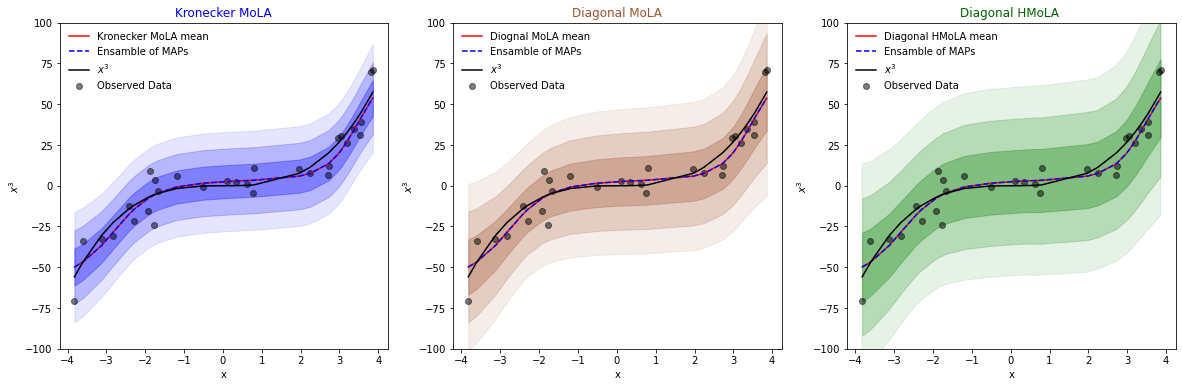

In [252]:
std_pp = np.sqrt(var_pp)
# std_pp2 = np.sqrt(var_pp2)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(x.cpu(), LLA_K_mean, label='Kronecker MoLA mean', color = "red")
axs[0].plot(x.cpu(), MAP_mean, "--",label='Ensamble of MAPs',color="blue")

axs[0].fill_between(x.cpu().reshape(-1), LLA_K_mean+LLA_K_std,LLA_K_mean-LLA_K_std,alpha=0.3, color = "blue")
axs[0].fill_between(x.cpu().reshape(-1), LLA_K_mean+2*LLA_K_std,LLA_K_mean-2*LLA_K_std,alpha=0.2, color = "blue")
axs[0].fill_between(x.cpu().reshape(-1), LLA_K_mean+3*LLA_K_std,LLA_K_mean-3*LLA_K_std,alpha=0.1, color = "blue")

axs[0].scatter(x.cpu().reshape(-1), y.cpu().reshape(-1), label='Observed Data',color="black", alpha = 0.5)
axs[0].plot(x.cpu().reshape(-1), x.cpu().reshape(-1)**3, label=r'$x^{3}$',color="black")

axs[0].set_title(f"Kronecker MoLA",color= "blue")
axs[0].set_xlabel(r"x")
axs[0].set_ylabel(r"$x^{3}$")
axs[0].set_ylim([-100, 100])
axs[0].legend(loc='best',frameon=False)

#################

axs[1].plot(x.cpu().reshape(-1), LLA_D_mean, label='Diognal MoLA mean', color = "red")
axs[1].plot(x.cpu().reshape(-1), MAP_mean, "--",label='Ensamble of MAPs',color="blue")

axs[1].fill_between(x.cpu().reshape(-1), LLA_D_mean+LLA_D_std,LLA_D_mean-LLA_D_std,alpha=0.3, color = "sienna")
axs[1].fill_between(x.cpu().reshape(-1), LLA_D_mean+2*LLA_D_std,LLA_D_mean-2*LLA_D_std,alpha=0.2, color = "sienna")
axs[1].fill_between(x.cpu().reshape(-1), LLA_D_mean+3*LLA_D_std,LLA_D_mean-3*LLA_D_std,alpha=0.1, color = "sienna")

axs[1].scatter(x.cpu().reshape(-1), y.cpu().reshape(-1), label='Observed Data',color="black", alpha = 0.5)
axs[1].plot(x.cpu().reshape(-1), x.cpu().reshape(-1)**3, label=r'$x^{3}$',color="black")

axs[1].set_title(f"Diagonal MoLA",color = "sienna")
axs[1].set_xlabel(r"x")
axs[1].set_ylabel(r"$x^{3}$")
axs[1].set_ylim([-100, 100])
axs[1].legend(loc='best',frameon=False)

#######
axs[2].plot(x.cpu().reshape(-1), mu_pp, label='Diagonal HMoLA mean', color = "red")
axs[2].plot(x.cpu().reshape(-1), MAP_mean, "--",label='Ensamble of MAPs',color="blue")

axs[2].fill_between(x.cpu().reshape(-1), mu_pp+std_pp,mu_pp-std_pp,alpha=0.3, color = "green")
axs[2].fill_between(x.cpu().reshape(-1), mu_pp+2*std_pp,mu_pp-2*std_pp,alpha=0.2, color = "green")
axs[2].fill_between(x.cpu().reshape(-1), mu_pp+3*std_pp,mu_pp-3*std_pp,alpha=0.1, color = "green")

axs[2].scatter(x.cpu().reshape(-1), y.cpu().reshape(-1), label='Observed Data',color="black", alpha = 0.5)
axs[2].plot(x.cpu().reshape(-1), x.cpu().reshape(-1)**3, label=r'$x^{3}$',color="black")

axs[2].set_title(f"Diagonal HMoLA ", color="darkgreen")
axs[2].set_xlabel(r"x")
axs[2].set_ylabel(r"$x^{3}$")
axs[2].set_ylim([-100, 100])
axs[2].legend(loc='best',frameon=False)


In [151]:
samples = einet.sample(200)

In [161]:
einet.einet_layers[0].ef_array

TypeError: 'Parameter' object is not callable

In [12]:
train_N = torch.normal(mean=torch.tensor(-50.0472), std=torch.tensor(466.9229),size=(100, 1))
train_N = train_N.to(device)

In [13]:
num_epochs = 10

for epoch_count in range(num_epochs):
    einet.train()
    #####

    #idx_batches = torch.randperm(train_N, device=device).split(batch_size)

    total_ll = 0.0
    #for idx in idx_batches:
    #    batch_x = train_x[idx, :]
    outputs = einet.forward(train_N)
    ll_sample = EinsumNetwork.log_likelihoods(outputs)
    log_likelihood = ll_sample.sum()
    log_likelihood.backward()

    einet.em_process_batch()
    total_ll += log_likelihood.detach().item()

    einet.em_update()

[]

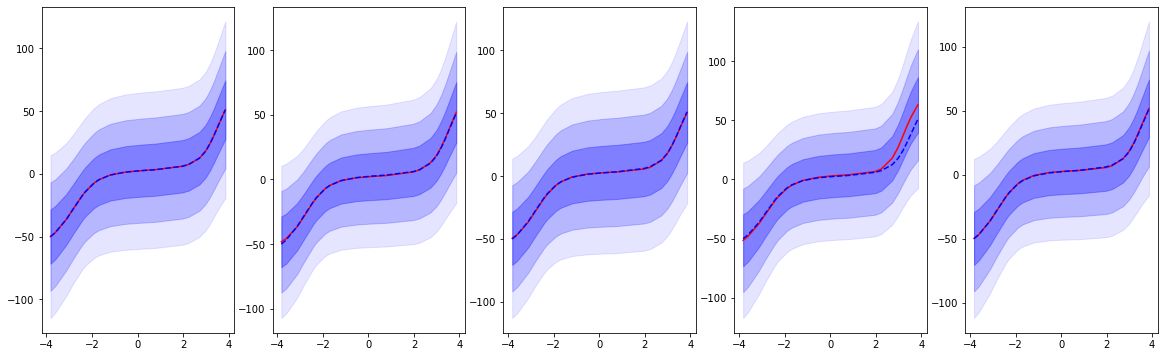

In [15]:
fig, axs = plt.subplots(1, 5, figsize=(20, 6))

for c, ax in enumerate(axs):

    la = LA[c]

    f_mu, f_var = la(x)
    f_mu = f_mu.squeeze().detach().cpu().numpy()
    f_sigma = f_var.squeeze().sqrt().cpu().numpy()
    pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

    output = models[0](x)

    ax.plot(x.cpu().numpy(), f_mu, label='Mean prediction', color = "red")
    ax.plot(x.cpu().numpy(), output.detach().cpu().numpy(), "--",label='NN prediction',color="blue")
    ax.fill_between(x.cpu().numpy().reshape(-1), f_mu+pred_std,f_mu-pred_std,alpha=0.3, color = "blue")
    ax.fill_between(x.cpu().numpy().reshape(-1), f_mu+2*pred_std,f_mu-2*pred_std,alpha=0.2, color = "blue")
    ax.fill_between(x.cpu().numpy().reshape(-1), f_mu+3*pred_std,f_mu-3*pred_std,alpha=0.1, color = "blue")

plt.plot()